In [69]:
import numpy as np
import os
import pickle
from utilities_ketamine_analysis_v8 import *
from utils_signal_processing import *
from utils_plotting import *
from utils_general import *

### Load behavior for all sessions

In [2]:
speed_path = r'C:\Users\fentonlab\Desktop\Gino\behaviour\\'
x = np.load(os.path.join(speed_path, "x_aln.npy"), allow_pickle=True)
y = np.load(os.path.join(speed_path, "y_aln.npy"), allow_pickle=True)
speed = np.load(os.path.join(speed_path, "speed_aln.npy"), allow_pickle=True)
yaw = np.load(os.path.join(speed_path, "yaw_aln.npy"), allow_pickle=True)

In [3]:
beh_binned_all = []

for ipath in range(0,len(x)):
    # print(ipath)
    
    behavior_con = []
    behavior_con = np.array([x[ipath],y[ipath],yaw[ipath],speed[ipath]])
    
    beh_binned_all.append(behavior_con)

### Load paths and ephys files for spiking activity

In [4]:
out_path = Path(r'C:\Users\fentonlab\Desktop\Gino\HPC_channel_info\\')

sync_PATH = os.path.join(out_path,'sync_path_matched.pkl')
nt_PATH = os.path.join(out_path,'nt_path_matched.pkl')
ksort_PATH = os.path.join(out_path,'ksort_HPC_path_matched.pkl')
ts_ephys_PATH = os.path.join(out_path,'ts_ephys_aln.pkl')

with open(sync_PATH,'rb') as file:
    sync_path_matched = pickle.load(file)
    
with open(nt_PATH,'rb') as file:
    nt_path_matched= pickle.load(file)
    
with open(ksort_PATH,'rb') as file:
    ksort_HPC_path_matched = pickle.load(file)
    
with open(ts_ephys_PATH,'rb') as file:
    ts_ephys_aln = pickle.load(file)


In [5]:
sess = 0

### Load spike files for a given session (takes about 3 min)

In [6]:
# load HPC file names and store them in rec spikes at 250 Hz
path_spike = Path(r'Z:\NeuroPix\spk_ketamine\HPC\\')
rec_name = 'spk_250Hz_' + str(sess) + '.file'
spk_file_name = os.path.join(path_spike , rec_name)

with open(spk_file_name,'rb') as f:
    spikes_binned_all_HPC = pickle.load(f)
    
# load behavior and upsample to 250Hz

In [9]:
# check dimension of spikes and behaviour (at 100 Hz)
spikes_binned_all_HPC[0].shape[1], x[0].shape, speed[0].shape

(1800499, (720214,), (720214,))

In [10]:
spk = spikes_binned_all_HPC

### Load LFP for a given session 

In [73]:
binFullPath = r'C:\Users\fentonlab\Desktop\Gino\LFPs'
HPC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','HPC_lfp_paths.file')
PFC_path_file = os.path.join(r'C:\Users\fentonlab\Desktop\Gino\LFPs','PFC_lfp_paths.file')

# ====== Load Lfp and speed data for a specific recording and brain area 
Lfp, _ , gain, rec = load_data(binFullPath,HPC_path_file,PFC_path_file,"HPC",sess)

Loading file in:  Z:\NeuroPix\Ketamine\2022-07-27-07-41-00_M015_SAL_PFC_HPC_0_0_0mpk\07-27-2022-M015_SAL_0.09_0.3_0.9_g0_imec1\07-27-2022-M015_SAL_0.09_0.3_0.9_g0_t0.imec1.lf.bin
Gain factors all the same for each Lfp channel: 9.375e-06 in Volts
                                                   Name_file  rec_id  \
0     2022-07-27_07-41-00_M015_SAL_PFC_HPC_0_0_0mpk_HPCprobe     0.0   
1     2022-07-28_13-19-00_M016_SAL_PFC_HPC_0_0_0mpk_HPCprobe     1.0   
2  2022-08-01_04-30-00_M015_RSK_mPFC_HPC_3_10_30mpk_HPCprobe     2.0   
3  2022-08-03_12-45-00_M015_RSK_mPFC_HPC_3_10_30mpk_HPCprobe     3.0   
4  2022-08-04_03-45-00_M016_RSK_mPFC_HPC_3_10_30mpk_HPCprobe     4.0   

   Lfp start     Lfp end  theta_start Unnamed: 5  theta_end  Unnamed: 7  \
0    24077.0  18029080.0         94.0         95      171.0        77.0   
1    56145.0  18614969.0         93.0         93      148.0        55.0   
2    87594.0  18093008.0         75.0         75      131.0        56.0   
3    62372.0  1806430

In [11]:
## load spk files
## load behavior at 100 Hz
## upsample behavior to 250Hz
## load lfp at 250 hz of that recording

In [12]:
## spk_mask = true/false per cell when it spikes at 250 Hz
## phase_mask = hilbert transform of lfp to phase at 250Hz per frequency band (every 4-8 Hz)
## histogram1D with spk_mask as weights


#### Upsample behavior at 250 Hz

In [74]:
def upsample_behaviour(spk, speed, x, y, sess, spk_rate = 250, behav_rate = 100):
    
    # time length for speed and spike variables
    behav_T = np.linspace(0, len(speed[sess])/ behav_rate, len(speed[sess]))
    spk_T = np.linspace(0, spk[0].shape[1]/ spk_rate, spk[0].shape[1]) # all cells have same time length

    # interpolate speed variable based on spike 
    interpolator = interp1d(behav_T, speed[sess], kind = 'linear', fill_value="extrapolate")
    speed_upsampled = interpolator(spk_T)
    
    # interpolate x variable based on spike 
    interpolator = interp1d(behav_T, x[sess], kind = 'linear', fill_value="extrapolate")
    x_upsampled = interpolator(spk_T)
    
    # interpolate y variable based on spike 
    interpolator = interp1d(behav_T, y[sess], kind = 'linear', fill_value="extrapolate")
    y_upsampled = interpolator(spk_T)
    
    # check if upsample done correctly
    if (speed_upsampled.size - spk[0].shape[1]) !=0:
        sys.exit("Speed upsampled size and spike size are not the same!")
    print('speed upsampled shape {}, spike shape {}'.format(speed_upsampled.shape, spk[0].shape))
    
    return speed_upsampled, x_upsampled, y_upsampled

In [77]:
speed_up, x_up, y_up = upsample_behaviour(spk, speed, x, y, sess)
beh_data = [None,None]
beh_data[0] = x_up
beh_data[1] = y_up

speed upsampled shape (1800499,), spike shape (565, 1800499)


1800500.3

#### Subsample Lfp at 250 Hz

In [80]:
LfpS = Lfp[::10,:] # original Lfp is sampled at 2500 Hz 
LfpS.shape

(1800501, 154)

In [81]:
# spike time of cell 0
spk[0][0][0:100]
# mapping array between cell number and LFP channel
spk[2][0:10]

array([2, 3, 3, 2, 1, 0, 5, 2, 2, 1], dtype=int64)

In [82]:
# Path for the session currently being analyzed
ksort_HPC_path_matched[sess]

WindowsPath('C:/Users/fentonlab/Desktop/Tony/Neurotar_HPC_ketamine/SPK/electrophysiology/2022-07-27_07-41-00_M015_SAL_PFC_HPC_0_0_0mpk_HPCprobe')

In [86]:
# CELL Properties 
# OUTPUT:
# occupation map, 
# rate_maps_temp (rate firing map -- raw, not smoothed)
# rate_maps_sm (rate firing map -- smoothed)
# LinMapsTemp_temp (rate firing map in 1D)

def place_cell_properties(spk_data, beh_data, binsxy, fsrate, shuf_state):
    from scipy.ndimage import gaussian_filter

    occ, rate_maps_sm, rate_maps_temp, LinMapsTemp_temp, p_info, coh = [], [], [], [], [], []
    nRepeat = 50  # number of shuffles

    # COMPUTING THE RATE MAPS
    occ = np.histogram2d(beh_data[0], beh_data[1], bins=binsxy)[0] / fsrate
    fig = plt.figure(figsize=(2, 2))
    ax = fig.add_subplot(1, 1, 1)
    sns.heatmap(occ, cmap='jet', ax=ax)    
    plt.show()
    
    # raw firing rate map
    rate_maps_temp = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]
                      / occ for s in spk_data]
    
#     ## radial version
#     Xcenter = beh_data[0] - (np.nanmax(beh_data[0]) + np.nanmin(beh_data[1])) / 2
#     Ycenter = beh_data[1] - (np.nanmax(beh_data[1]) + np.nanmin(beh_data[0])) / 2
    
#     alpha = np.arctan2(Ycenter, Xcenter)

#     L_occ = np.histogram(alpha, bins=binsxy)[0] /fsrate
    # LinMapsTemp_temp = [np.histogram(alpha, bins=30, weights=s)[0] / L_occ
    #      for s in spk_data]
    
    # get NaN index 
    idx_nan = [np.isnan(p) for p in rate_maps_temp]

    # smooth map 
    rate_maps_sm = [gaussian_filter(np.nan_to_num(p), sigma=1) for p in rate_maps_temp] # not higher than 1.5
    
    for icell in range(0,len(rate_maps_sm)):
        
        rate_maps_sm[icell][idx_nan[icell]] = np.nan
        


    # analyze rate maps
    p_info = [place_info_content(occ, m) for m in rate_maps_temp]
    coh = [neighbor_sum(m) for m in rate_maps_temp]

    ## pinfo and coherence
    print('Place info', np.hstack(p_info))
    print('Coherence', np.hstack(coh))

#     # plot firing rate maps
#     for icell in range(0,len(rate_maps_sm)):
#         print('p_info',p_info[icell],'coherence',coh[icell])
#         fig = plt.figure(figsize=(2, 2))
#         ax = fig.add_subplot(1, 1, 1)
#         sns.heatmap(rate_maps_sm[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
#         ax.set_xlabel('X position')
#         ax.set_ylabel('Y position')
#         fname = 'Cell' + str(icell)
#         ax.set_title(fname)
#         plt.show()        
    
    
    if shuf_state == True:
        # Randomizing
        sTrackedCopy = spk_data.copy()
        sTrackedTimePairs = list(zip(*sTrackedCopy))

        pInfoShuffled = []
        cohShuffled = []
        for iRand in range(nRepeat):
            np.random.shuffle(sTrackedTimePairs)
            sShuffled = list(zip(*sTrackedTimePairs))

            RateMapsShuffled = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]
                                / occ for s in sShuffled]
            pInfoShuffled.append([place_info_content(occ, m) for m in RateMapsShuffled])

            cohShuffled.append([neighbor_sum(m) for m in RateMapsShuffled])

        pInfoTest = []
        for p, z in zip(p_info, zip(*pInfoShuffled)):
            Out = [p, (p - np.mean(z)) / np.std(z)]
            pInfoTest.append([Out, Out[0] > 1 and Out[1] > 1.96])

        cohTest = []
        for p, z in zip(coh, zip(*cohShuffled)):
            Out = [p, (p - np.mean(z)) / np.std(z)]
            testTmp = Out[0] > 0.5 and Out[1] > 1.96
            cohTest.append([Out, testTmp])

        # determine whether cells are place cells
        PC_test = [c[0][1] > 1.96 and p[0][1] > 1.96 for c, p in zip(cohTest, pInfoTest)]
        # fr_test = [(np.sum(s)/(s.size/fsrate))<5 for s in spk_data]
        
    if shuf_state == False:
    
        PC_test = [c> 0.4 and p> 0.7 for c, p in zip(coh, p_info)]
        # fr_test = [(np.sum(s)/(s.size/fsrate))<5 for s in spk_data]

    # PC_fr_test = [p*q for p,q in zip(PC_test, fr_test)]    
    PC_fr_test = [p for p in zip(PC_test)]    

    print('number of PCs', np.sum(PC_fr_test), 'of', len(PC_test))

    ## plot firing rate maps
    for icell in np.hstack(np.argwhere(np.hstack(PC_fr_test) == True)):
        print('place information', p_info[icell])
        print('coherence', coh[icell])
        print('firing rate', np.sum(spk_data[icell])/(spk_data[icell].size/fsrate))

        fig = plt.figure(figsize=(2, 2))
        ax = fig.add_subplot(1, 1, 1)
#         sns.heatmap(rate_maps_temp_temp[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
        sns.heatmap(rate_maps_sm[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        fname = 'Cell' + str(icell)
        ax.set_title(fname)
        plt.show()

    return occ, rate_maps_temp, rate_maps_sm, LinMapsTemp_temp, p_info, coh, PC_fr_test



### Identify Place Cells in HPC

experiment C:\Users\fentonlab\Desktop\Tony\Neurotar_HPC_ketamine\SPK\electrophysiology\2022-07-27_07-41-00_M015_SAL_PFC_HPC_0_0_0mpk_HPCprobe


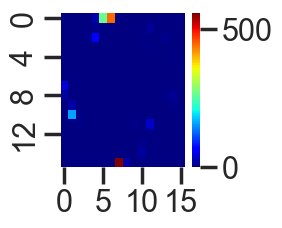

C:\Users\fentonlab\AppData\Local\Temp\ipykernel_30296\2977194271.py:22: RuntimeWarning: invalid value encountered in divide
  rate_maps_temp = [np.histogram2d(beh_data[0], beh_data[1], bins=binsxy, weights=s)[0]
C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: divide by zero encountered in log2
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: invalid value encountered in multiply
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\Desktop\Gino\Gino_codes\python\utilities_ketamine_analysis_v8.py:555: RuntimeWarning: invalid value encountered in divide
  info_map = (occ / T) * (rate_map / R) * np.log2(rate_map / R)
C:\Users\fentonlab\.conda\envs\bettinumbers\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Place info [ 0.08686315  0.16337422  0.59484149  4.77183736  2.14269163  0.37091934
  0.04251506  0.          0.08764394  0.13994437  1.36906343  0.
  0.13091505  0.20338553  0.          0.49825798  0.70554332  1.20082159
  1.910349    0.07276088  0.11971653  1.17965687  0.41147245  0.13860184
  1.87696348  1.72008818  0.18717606  0.6747853   1.004137    0.
  2.76783592  1.18462164  2.47339622  0.29772916  0.06532468  0.20127061
  0.12344209  1.45769768  2.26446586  0.1536707   0.82869436  0.18677869
  0.          1.38151842  0.58688031  1.08268492  0.67914253  0.1026339
  3.33253289  1.74041009  0.79346575  0.33979521  2.25069961  0.72094994
  0.          0.          0.09057906  0.81825619  0.95069058  2.08372381
  0.45186302  0.          0.08667074  1.39995991  1.11750272  0.76683468
  1.64998928  4.19113356  0.          3.50620695  0.85178716  0.44302536
  1.56473354  1.48238681  0.65199484  0.          1.13524613  0.26538693
  7.24234708  0.17079492  0.18578193  0.56605059  1.49923

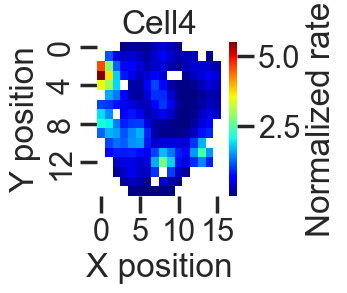

place information 0.7055433176236808
coherence 0.4590155180148221
firing rate 1.205


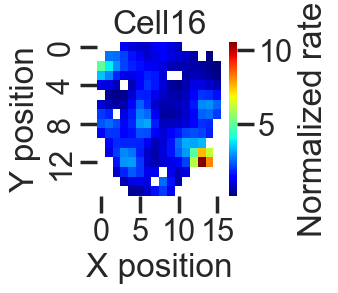

place information 1.004137002353566
coherence 0.43376390753197785
firing rate 0.09777777777777778


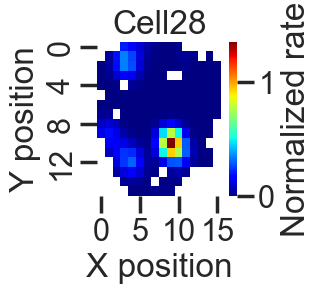

place information 2.767835915923204
coherence 0.40318925624907315
firing rate 0.0005555555555555556


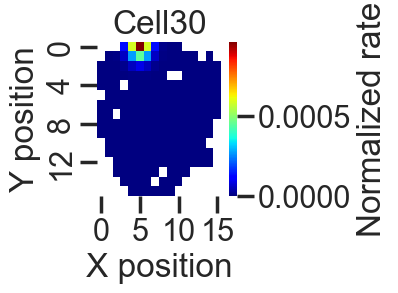

place information 1.184621642371889
coherence 0.40450299956355407
firing rate 0.022222222222222223


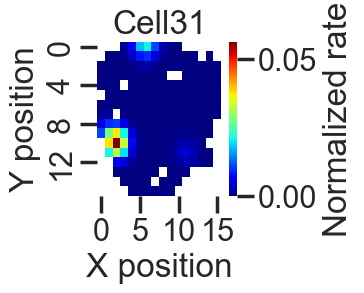

place information 1.457697677049437
coherence 0.4361697574862159
firing rate 0.395


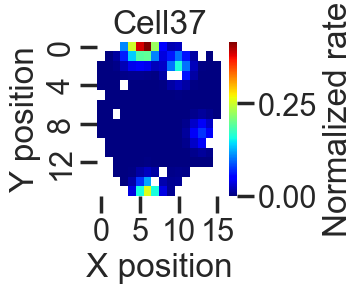

place information 2.2644658618734637
coherence 0.4805859172726096
firing rate 4.92


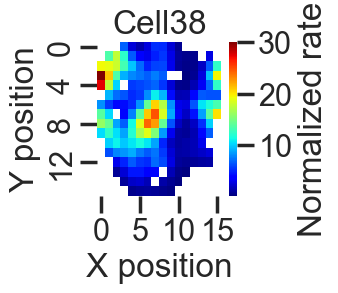

place information 0.8286943555702971
coherence 0.43303382095803905
firing rate 6.615


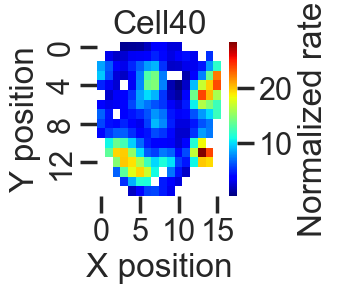

place information 1.0826849237777474
coherence 0.4321057516501974
firing rate 0.03888888888888889


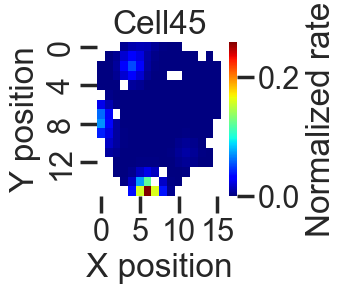

place information 1.3999599080316414
coherence 0.486898475598916
firing rate 0.11


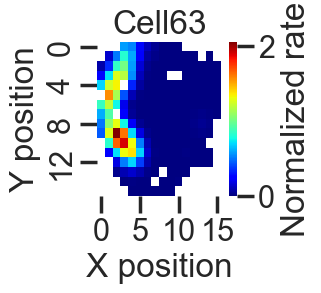

place information 0.7668346827945238
coherence 0.4264633161579277
firing rate 0.8372222222222222


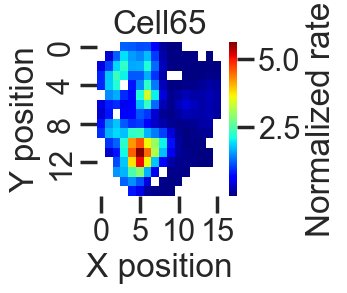

place information 0.8517871566492113
coherence 0.4981719316278057
firing rate 0.9594444444444444


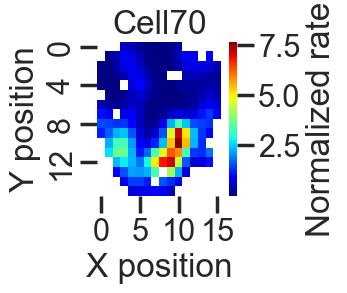

place information 1.4823868058604401
coherence 0.42596015495864487
firing rate 0.04722222222222222


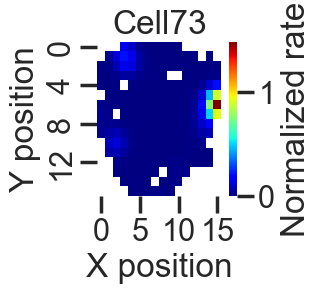

place information 1.1352461307167183
coherence 0.40372272656929536
firing rate 0.01


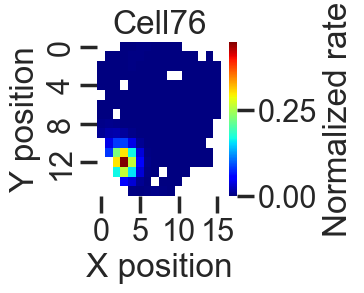

place information 2.5574506237486703
coherence 0.4745731432399181
firing rate 0.08888888888888889


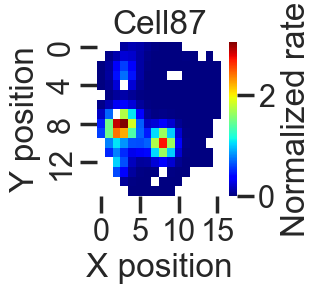

place information 0.9314558800228586
coherence 0.4005780801575601
firing rate 2.4916666666666667


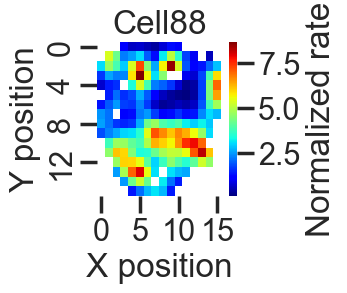

place information 0.9280711300315141
coherence 0.4347601034685758
firing rate 0.24833333333333332


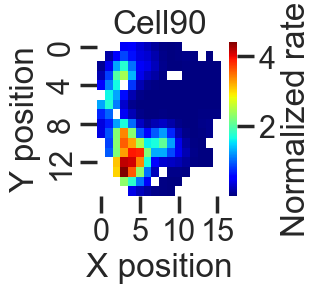

place information 2.0153288313923836
coherence 0.4031892562490702
firing rate 0.006111111111111111


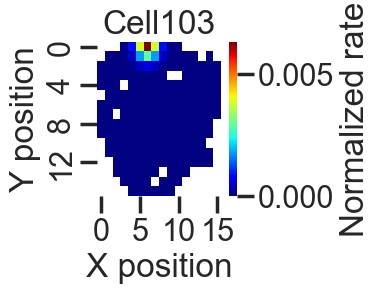

place information 1.0610384093944045
coherence 0.553412137147635
firing rate 0.5944444444444444


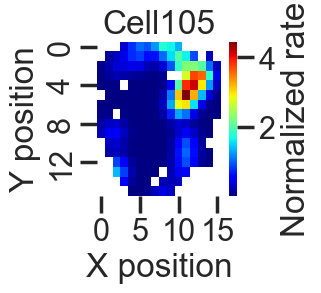

place information 1.6758151421282732
coherence 0.4375288024437556
firing rate 0.035


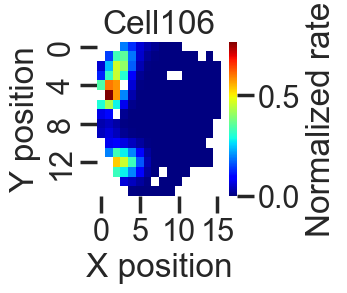

place information 0.8979526379586735
coherence 0.48253329063421746
firing rate 0.01


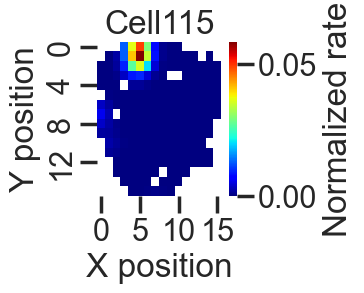

place information 1.2257913200268125
coherence 0.4247852353968062
firing rate 0.12611111111111112


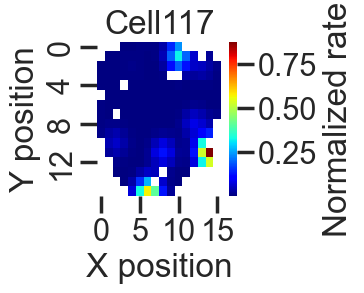

place information 0.7802628895345002
coherence 0.5468828588210487
firing rate 0.015555555555555555


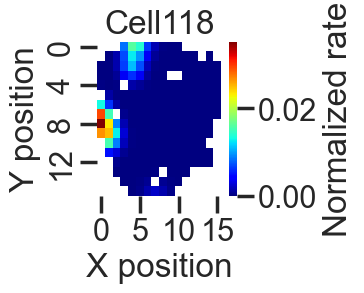

place information 0.7901667956929228
coherence 0.435090209927929
firing rate 0.2038888888888889


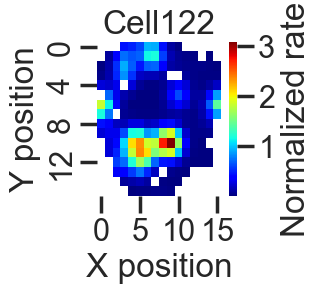

place information 2.530824906198065
coherence 0.40260535857403307
firing rate 0.0011111111111111111


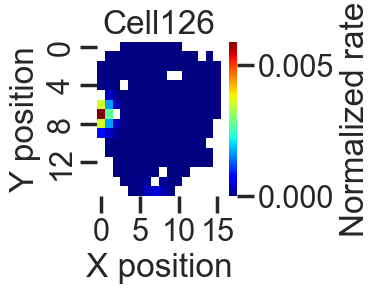

place information 1.5267597200774738
coherence 0.4475794054427671
firing rate 0.006111111111111111


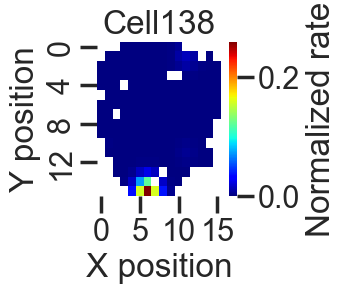

place information 1.0527622729901716
coherence 0.44132538571915386
firing rate 0.057777777777777775


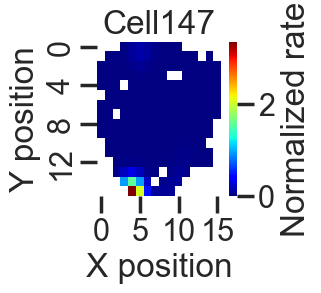

place information 1.1349352615061599
coherence 0.4172990745566023
firing rate 0.20722222222222222


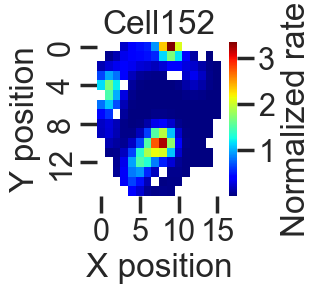

place information 2.873881950798233
coherence 0.42572018333956235
firing rate 0.19


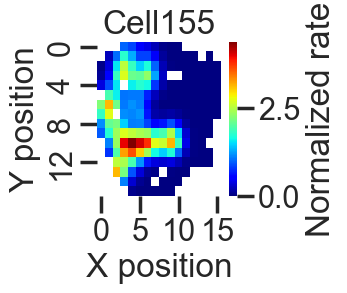

place information 4.892963267704172
coherence 0.4423386674685495
firing rate 0.0011111111111111111


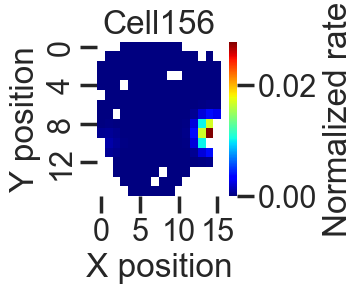

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0011111111111111111


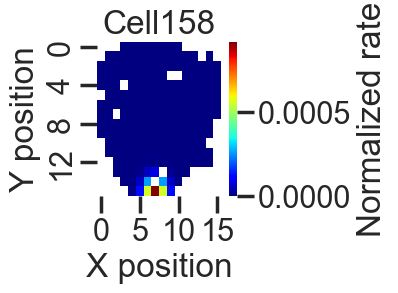

place information 1.8412668208654621
coherence 0.504360953824922
firing rate 0.0661111111111111


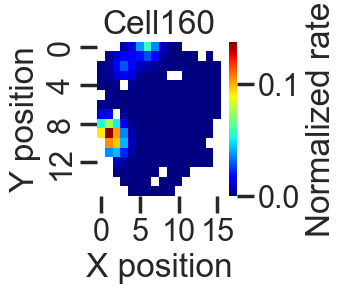

place information 1.2958925297694928
coherence 0.40267358882307513
firing rate 0.014444444444444444


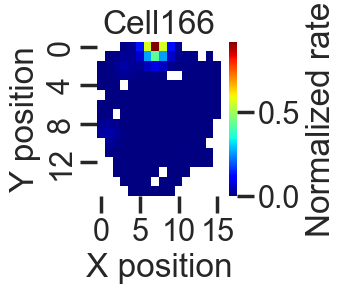

place information 1.0942728724073043
coherence 0.4274452533006712
firing rate 0.4727777777777778


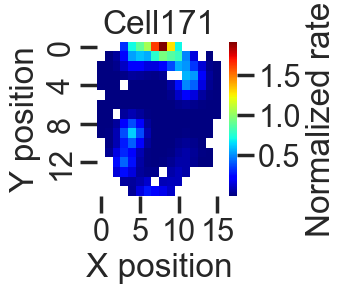

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0005555555555555556


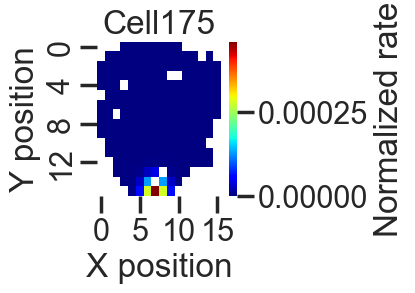

place information 1.339225756952935
coherence 0.46339227759673335
firing rate 1.0988888888888888


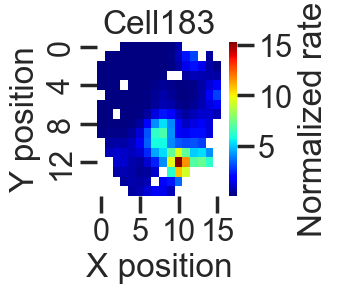

place information 1.1035264713836175
coherence 0.4969768182046069
firing rate 0.014444444444444444


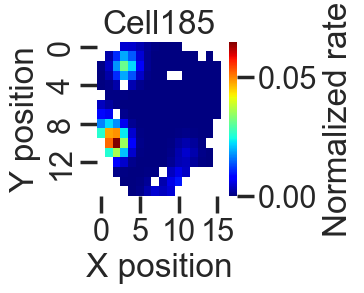

place information 1.3982947912423396
coherence 0.550390782772271
firing rate 0.18222222222222223


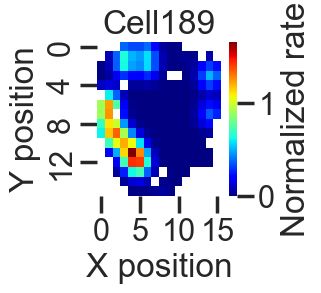

place information 0.9341188817015987
coherence 0.4596481917142985
firing rate 2.257222222222222


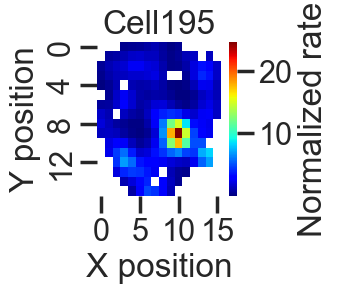

place information 0.7883451928764166
coherence 0.4552373035229475
firing rate 0.47833333333333333


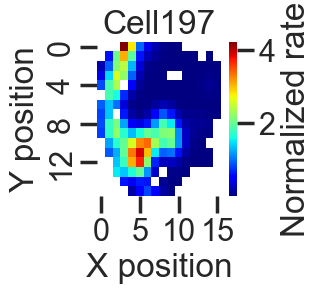

place information 1.0736304572344317
coherence 0.5616887766195489
firing rate 1.3677777777777778


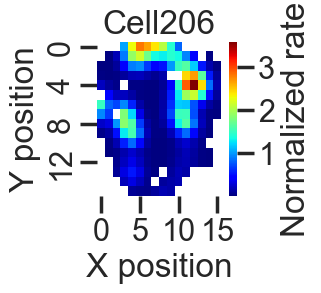

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0005555555555555556


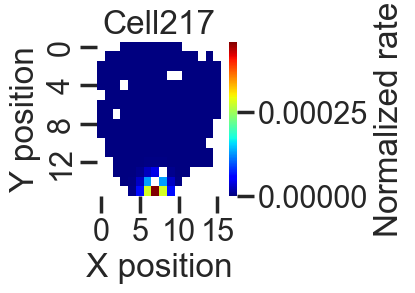

place information 0.9655920124097722
coherence 0.44151106815655494
firing rate 2.82


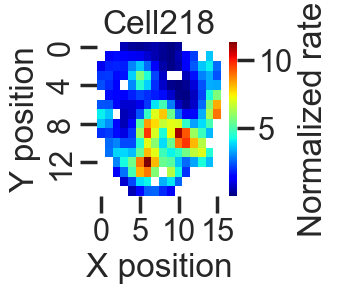

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0005555555555555556


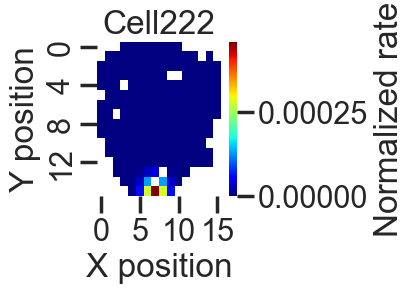

place information 1.0612820797243239
coherence 0.44416367117647204
firing rate 0.725


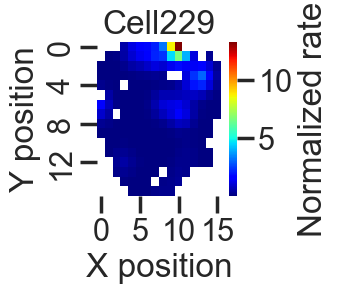

place information 0.8864600312122146
coherence 0.4443196186317716
firing rate 2.2111111111111112


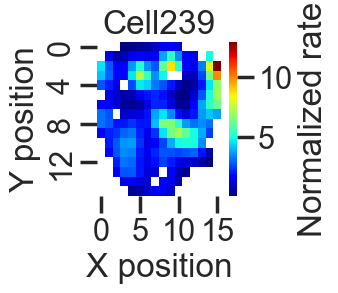

place information 0.7303228582019197
coherence 0.4725326912870131
firing rate 1.7255555555555555


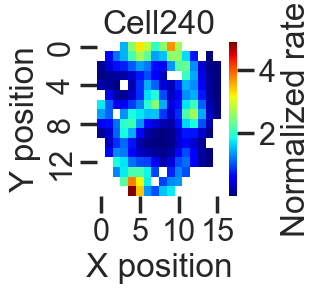

place information 0.9254557555542
coherence 0.47403894020511234
firing rate 2.111666666666667


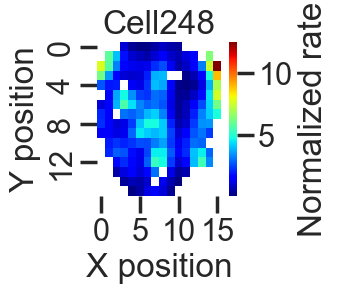

place information 0.8331380531478015
coherence 0.5073164087564596
firing rate 1.6305555555555555


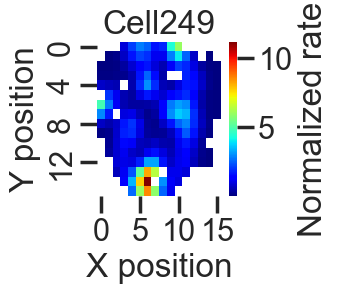

place information 0.9810549795573643
coherence 0.46561044134378216
firing rate 1.5138888888888888


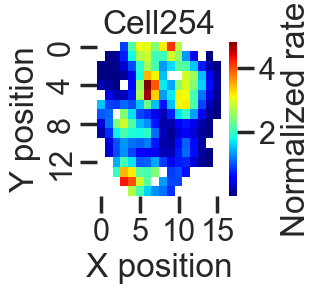

place information 0.8852809641412459
coherence 0.4258960616607094
firing rate 1.0027777777777778


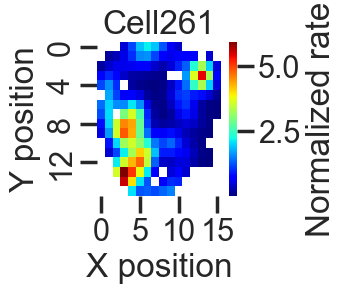

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0022222222222222222


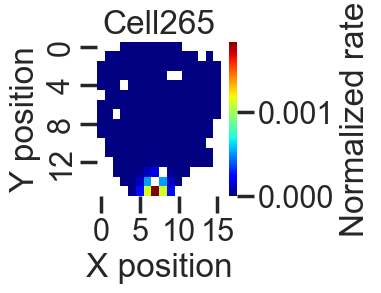

place information 1.9631777850978462
coherence 0.4135077361892669
firing rate 0.002777777777777778


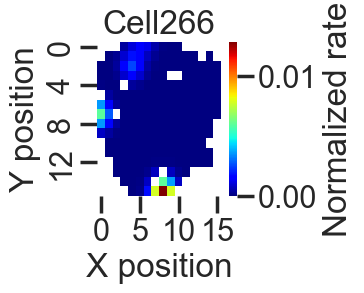

place information 0.9459378569438636
coherence 0.46965832313711536
firing rate 3.2394444444444446


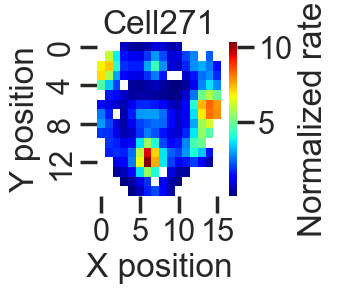

place information 0.7225238608088785
coherence 0.5404604686215027
firing rate 2.368888888888889


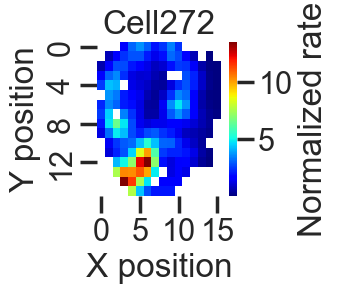

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


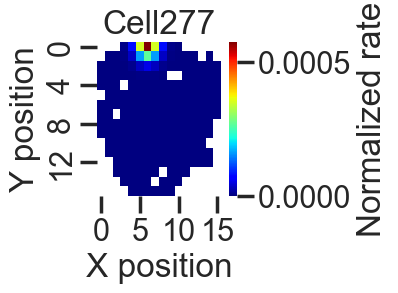

place information 0.7971658533930622
coherence 0.5698577155138351
firing rate 0.32


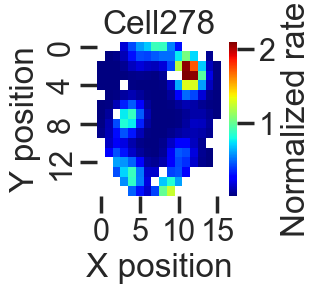

place information 0.7308221414890972
coherence 0.5167778065633709
firing rate 2.1983333333333333


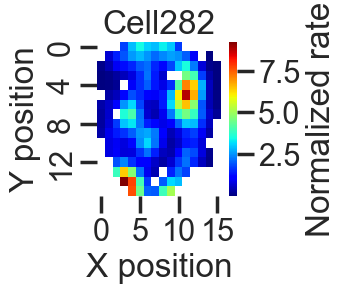

place information 0.9308282623549871
coherence 0.43447289268084754
firing rate 1.4283333333333332


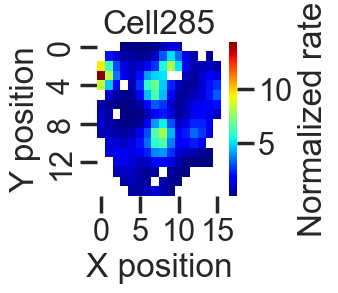

place information 0.7392897253314891
coherence 0.47623921601675007
firing rate 0.5355555555555556


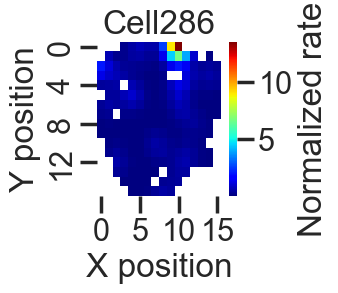

place information 0.990569395926796
coherence 0.4739253873015008
firing rate 3.415


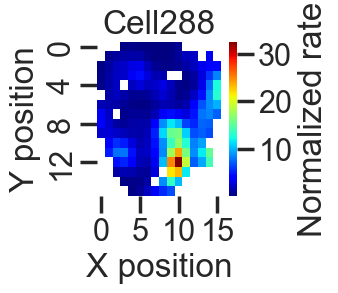

place information 0.867240401530888
coherence 0.4615979801635653
firing rate 3.0011111111111113


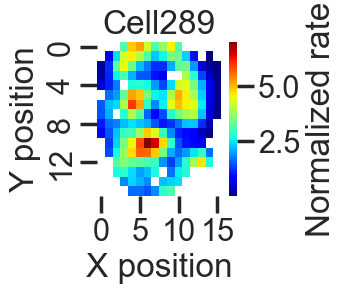

place information 0.7848658125493583
coherence 0.400637398229367
firing rate 3.071111111111111


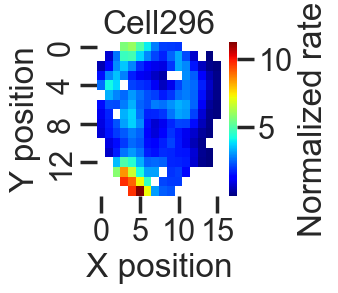

place information 0.9786826984132673
coherence 0.4310705525490084
firing rate 3.46


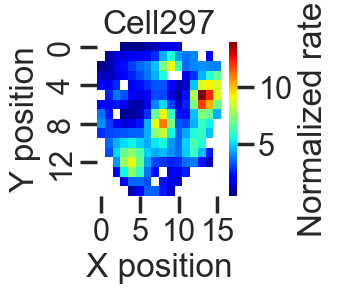

place information 2.1392926558505265
coherence 0.42496349759420654
firing rate 1.0788888888888888


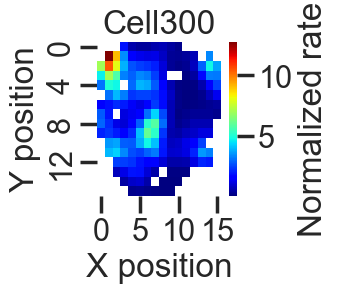

place information 5.370572396536944
coherence 0.4031892562490716
firing rate 0.0005555555555555556


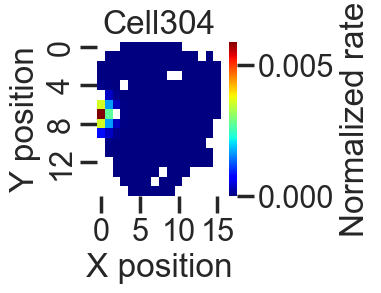

place information 1.5479957113537839
coherence 0.4045506840310166
firing rate 0.095


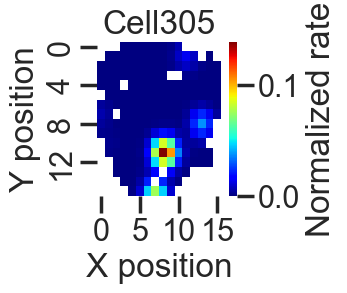

place information 0.811310470117296
coherence 0.46862524734352046
firing rate 0.285


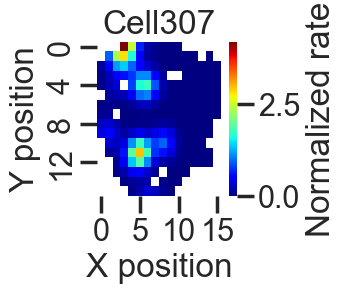

place information 0.8326660854527246
coherence 0.6403550101739981
firing rate 1.0711111111111111


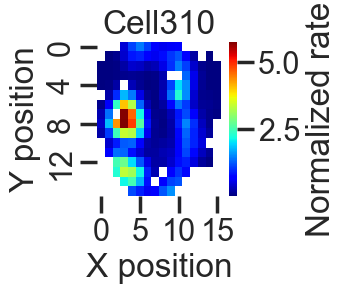

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0005555555555555556


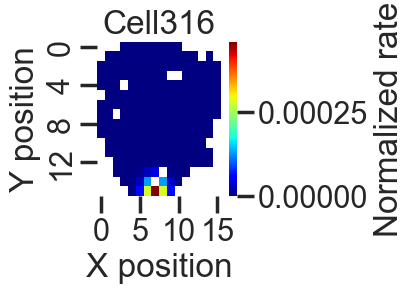

place information 0.7391562308356132
coherence 0.4669327766347679
firing rate 0.6616666666666666


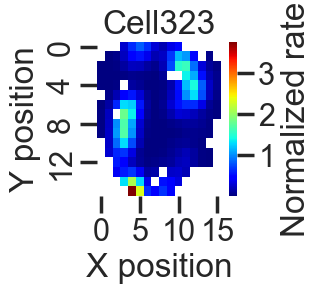

place information 1.0705385614535152
coherence 0.4272847466910421
firing rate 0.5122222222222222


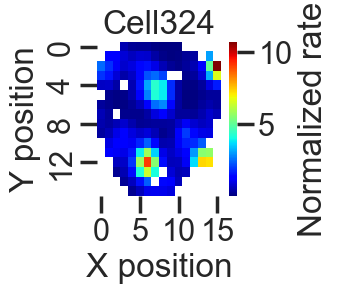

place information 1.5736461794819914
coherence 0.6200973229983449
firing rate 0.0661111111111111


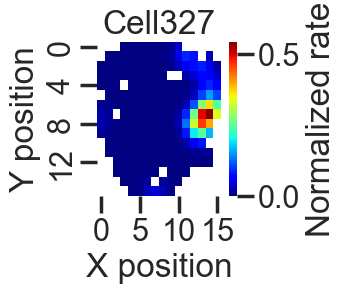

place information 0.9776360505405433
coherence 0.44352327277025705
firing rate 1.0594444444444444


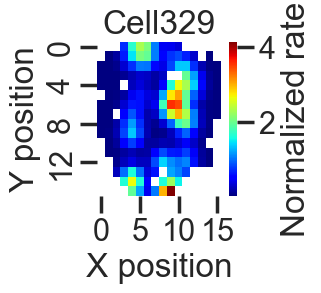

place information 0.7838968302458573
coherence 0.5784603344494895
firing rate 0.006111111111111111


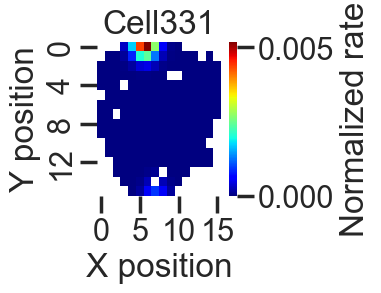

place information 1.0583689982486073
coherence 0.4094785551117465
firing rate 0.7144444444444444


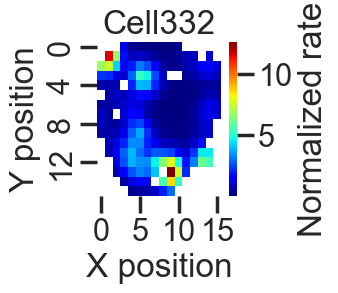

place information 0.9776619294979847
coherence 0.4174702355505563
firing rate 2.9544444444444444


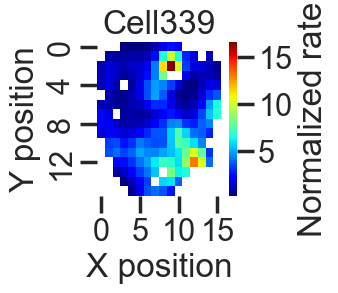

place information 1.0956059254753476
coherence 0.4072564117223535
firing rate 0.4772222222222222


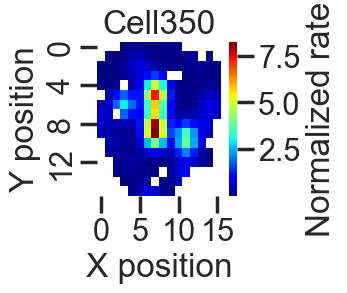

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


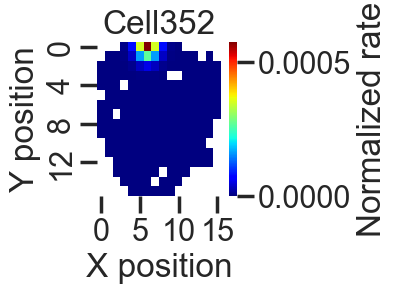

place information 1.0063185112480197
coherence 0.442012130173927
firing rate 2.488888888888889


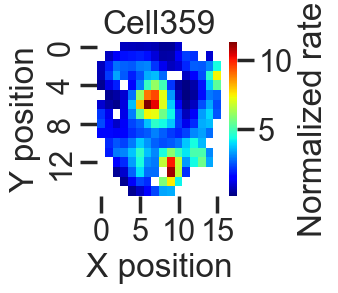

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0005555555555555556


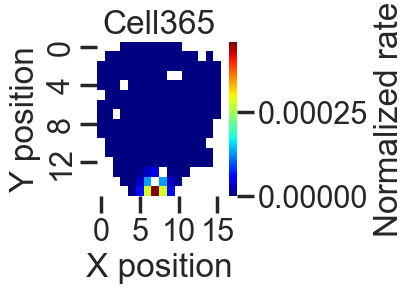

place information 3.283568790657215
coherence 0.4029343235569071
firing rate 0.0011111111111111111


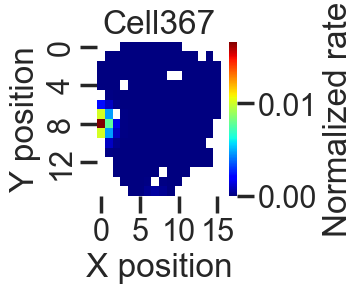

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


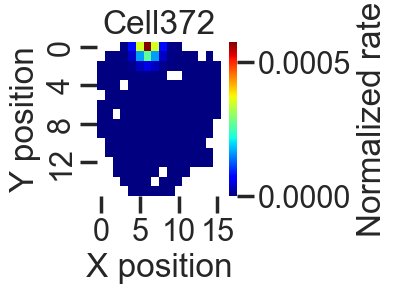

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0022222222222222222


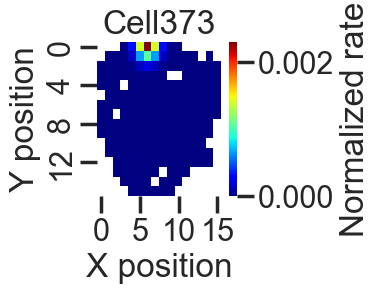

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


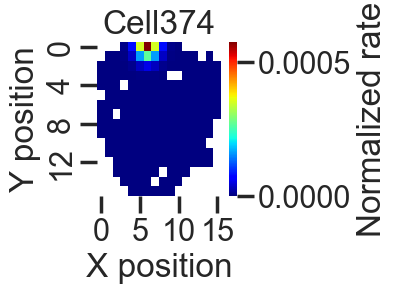

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0011111111111111111


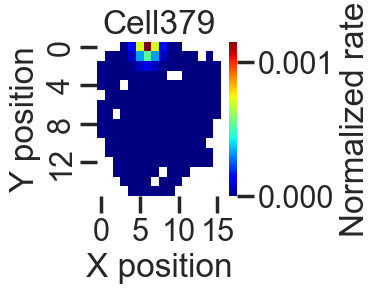

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


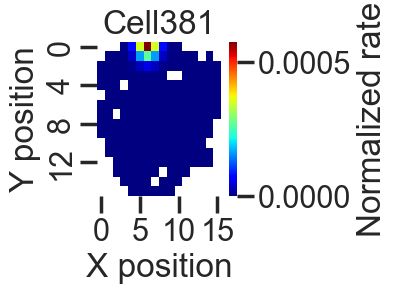

place information 2.0153288313923845
coherence 0.4031892562490742
firing rate 0.0038888888888888888


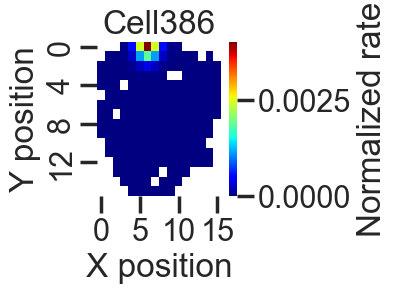

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


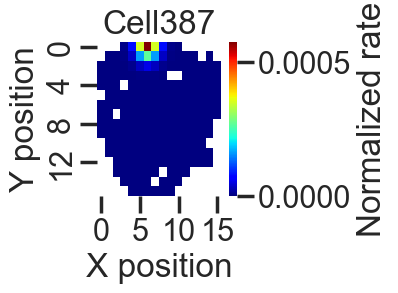

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


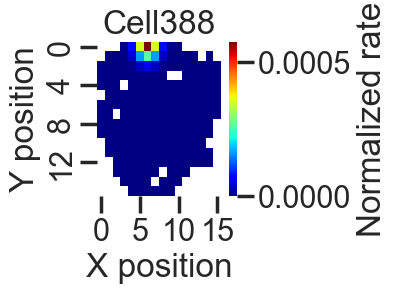

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


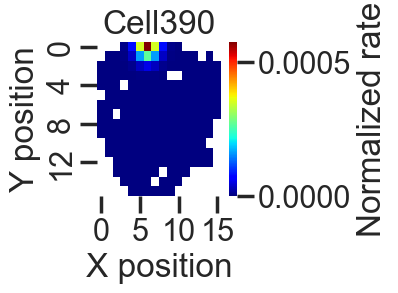

place information 1.122987853049952
coherence 0.402967420648591
firing rate 0.0022222222222222222


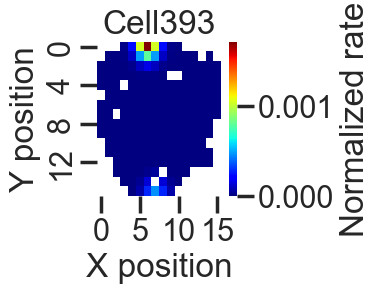

place information 3.0614963881243566
coherence 0.5139505596984325
firing rate 0.11055555555555556


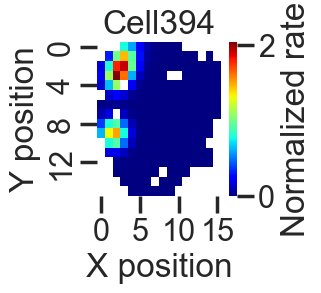

place information 1.2129925675529944
coherence 0.42489191807799565
firing rate 0.9438888888888889


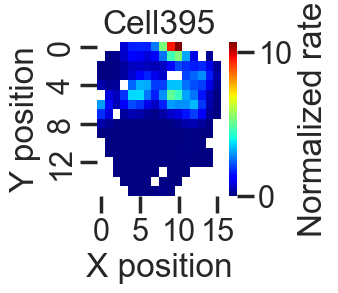

place information 1.229456665891195
coherence 0.40578992323293
firing rate 0.0011111111111111111


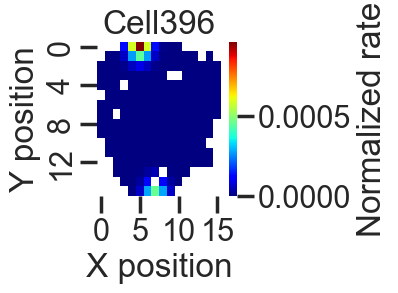

place information 2.2501176931890545
coherence 0.5078873790249487
firing rate 0.022222222222222223


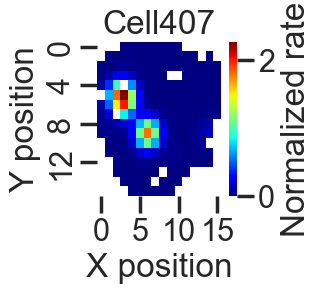

place information 1.285225455623782
coherence 0.46518151481583214
firing rate 0.6572222222222223


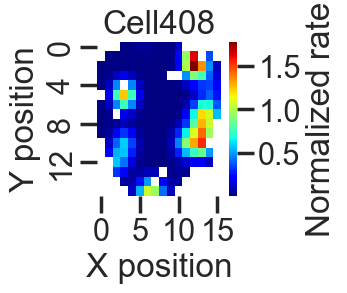

place information 1.0609447530580867
coherence 0.4890510256182857
firing rate 1.6144444444444443


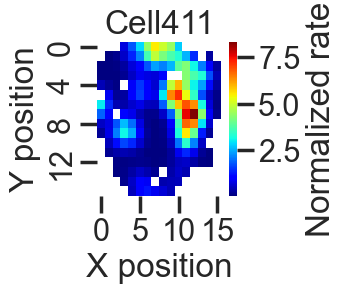

place information 0.7295532872107104
coherence 0.5972783248561052
firing rate 0.002777777777777778


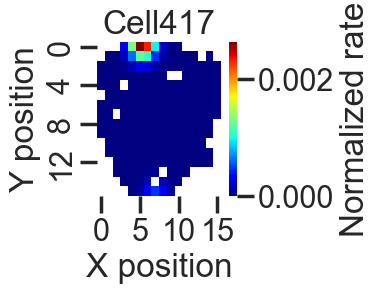

place information 0.8102142211885923
coherence 0.44167643631966075
firing rate 0.029444444444444443


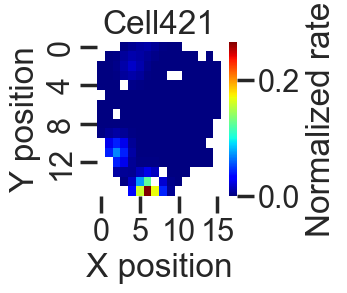

place information 1.046905565180841
coherence 0.5853161259555049
firing rate 0.11222222222222222


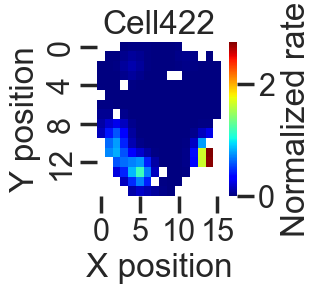

place information 1.2335650256785478
coherence 0.442239811391861
firing rate 0.01611111111111111


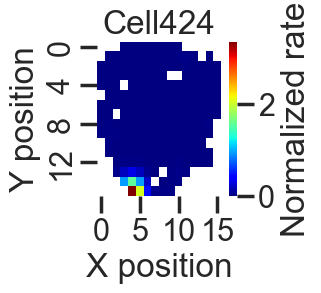

place information 1.7121935089660636
coherence 0.5455352799532568
firing rate 0.06055555555555556


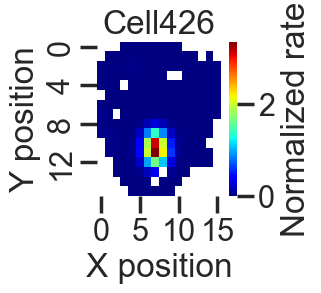

place information 0.9823440161209114
coherence 0.4455573293459929
firing rate 0.03888888888888889


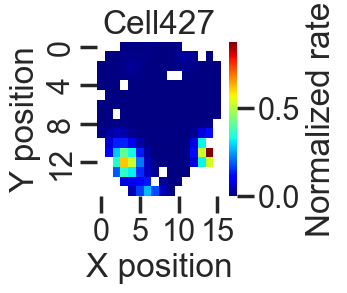

place information 1.1934020731477462
coherence 0.4648219859926083
firing rate 0.24888888888888888


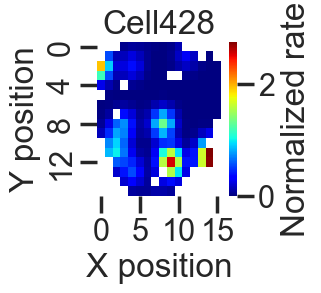

place information 0.7135936213172343
coherence 0.45163086299053723
firing rate 0.014444444444444444


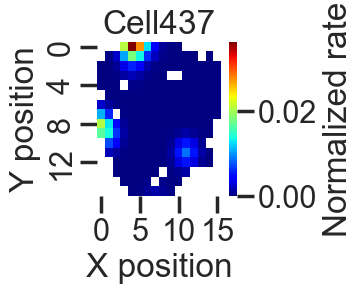

place information 0.8217930217482199
coherence 0.41912022812464184
firing rate 0.06833333333333333


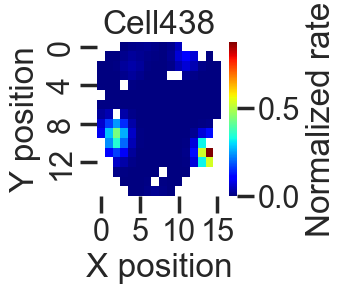

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0011111111111111111


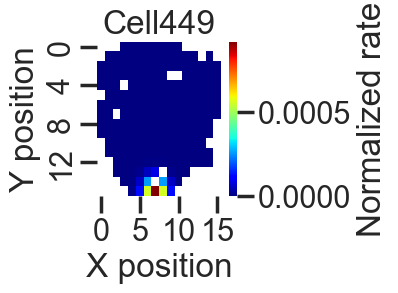

place information 1.2883202489341075
coherence 0.4689409680977865
firing rate 3.743888888888889


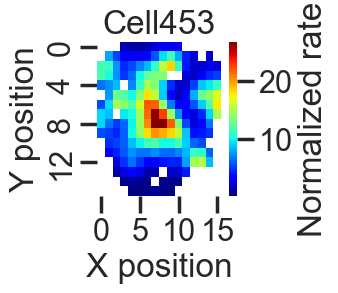

place information 2.767835915923204
coherence 0.40318925624907315
firing rate 0.0005555555555555556


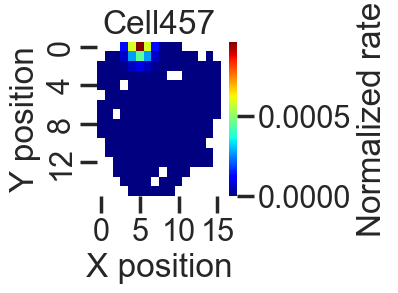

place information 6.876060165455244
coherence 0.4031892562490738
firing rate 0.0005555555555555556


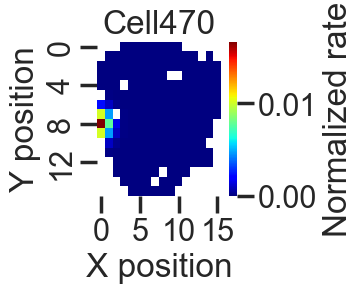

place information 0.973503211512753
coherence 0.44871878842184076
firing rate 0.012222222222222223


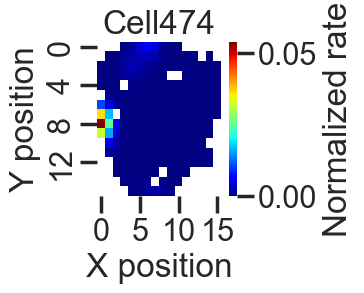

place information 1.440697047208349
coherence 0.40154417380862256
firing rate 0.0016666666666666668


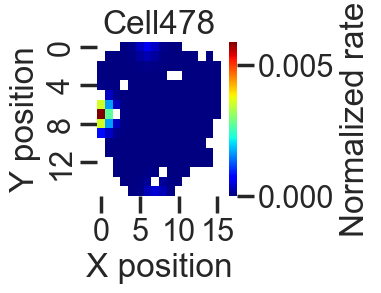

place information 1.5139080962497826
coherence 0.4025592788803928
firing rate 0.005555555555555556


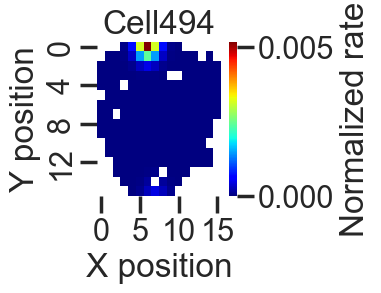

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0005555555555555556


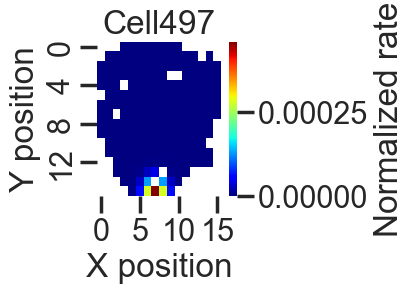

place information 1.3112645071551638
coherence 0.4024616422995605
firing rate 0.0033333333333333335


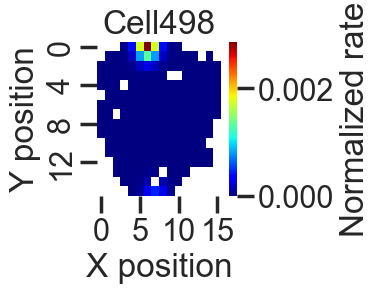

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


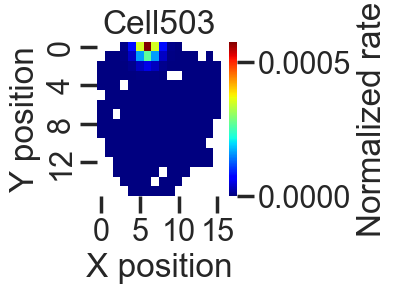

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0011111111111111111


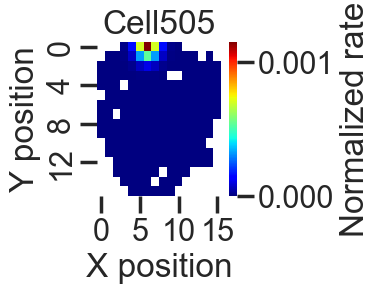

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


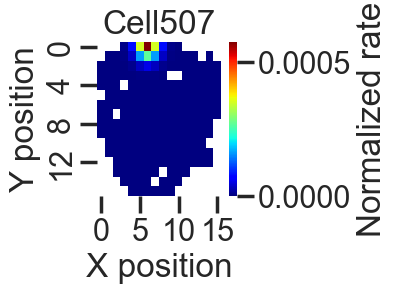

place information 2.0153288313923845
coherence 0.403189256249074
firing rate 0.005555555555555556


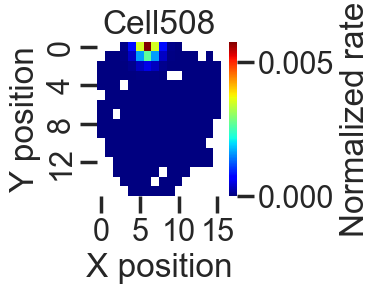

place information 1.0015858290726163
coherence 0.41034603005247416
firing rate 0.0044444444444444444


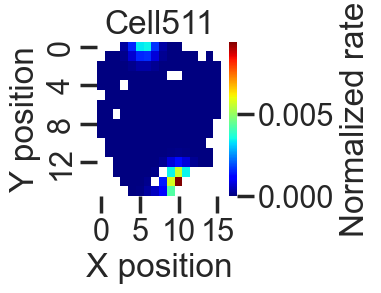

place information 1.8507749348574507
coherence 0.42812066377729535
firing rate 0.04611111111111111


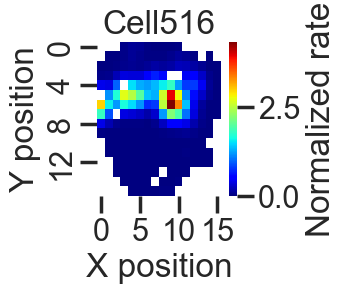

place information 0.9272965140192584
coherence 0.42139852899264063
firing rate 0.5038888888888889


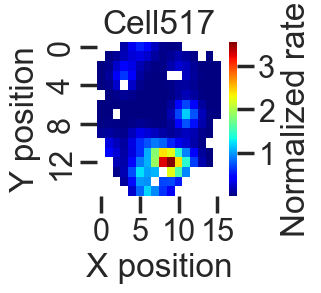

place information 1.3382742672139714
coherence 0.4772336472954966
firing rate 0.2627777777777778


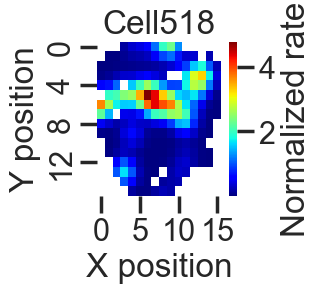

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0011111111111111111


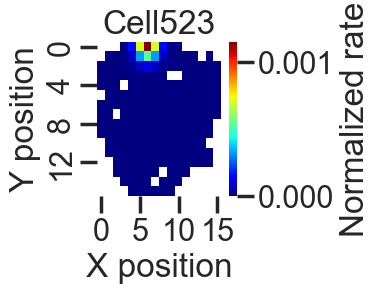

place information 0.8232583749623287
coherence 0.4210447180981293
firing rate 1.1583333333333334


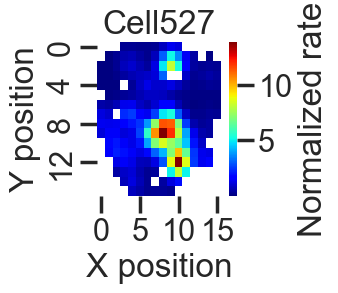

place information 10.82536916549225
coherence 0.4427856290582301
firing rate 0.0011111111111111111


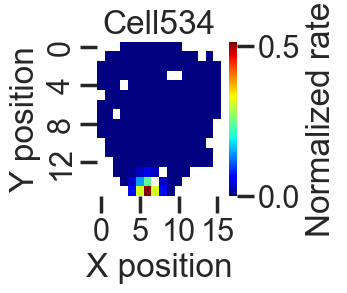

place information 0.8441130962579407
coherence 0.41676192157498154
firing rate 0.005


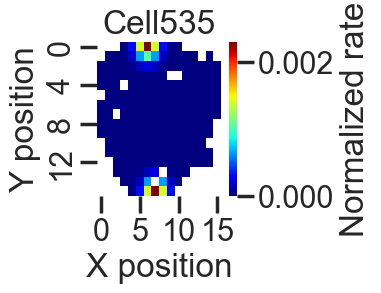

place information 1.0714475076092318
coherence 0.546153076219597
firing rate 0.08388888888888889


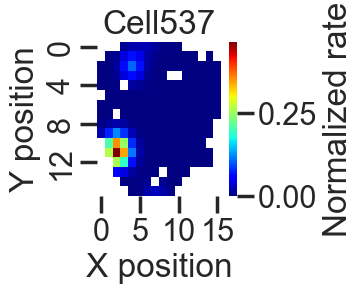

place information 1.5010529052726898
coherence 0.6429772965765954
firing rate 0.6483333333333333


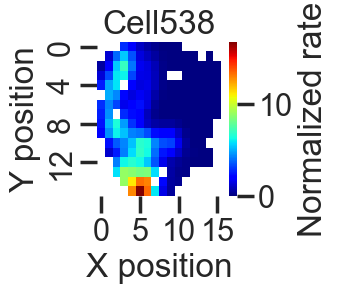

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


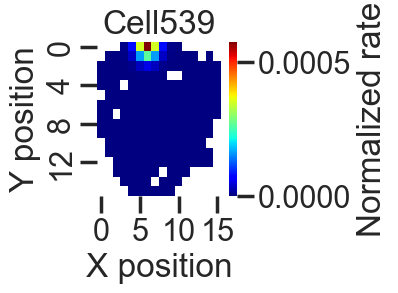

place information 0.8161187660901745
coherence 0.6000636482454015
firing rate 0.5394444444444444


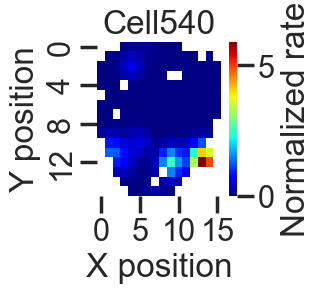

place information 0.988949192160162
coherence 0.4045476752066211
firing rate 0.0016666666666666668


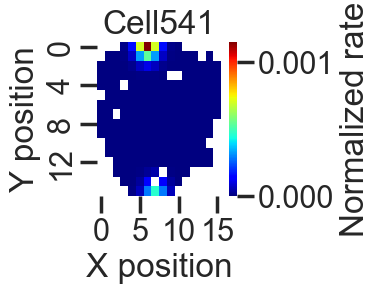

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0022222222222222222


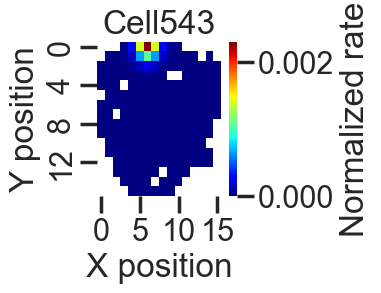

place information 1.6910774158591857
coherence 0.44278562905823016
firing rate 0.0005555555555555556


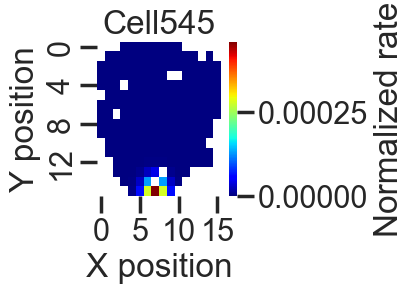

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0011111111111111111


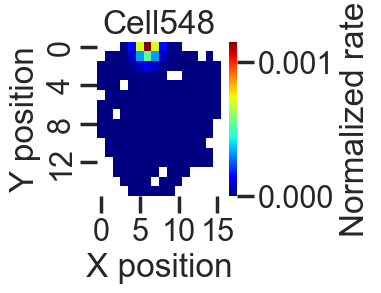

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0011111111111111111


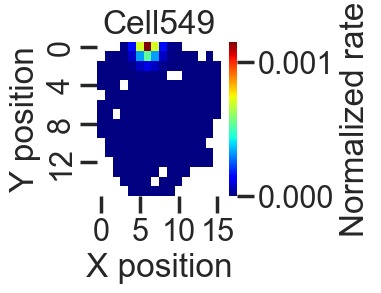

place information 1.0934250099877214
coherence 0.45070665092087664
firing rate 0.05555555555555555


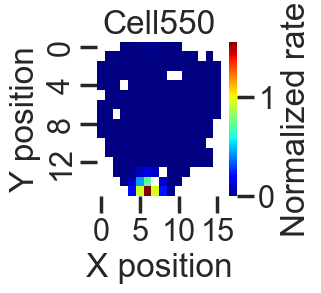

place information 0.7137838538697332
coherence 0.4298300863609357
firing rate 0.050555555555555555


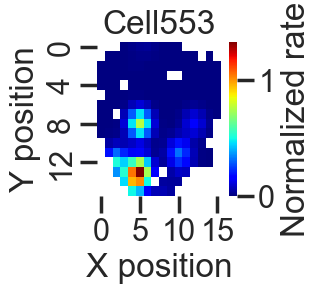

place information 1.839507507584935
coherence 0.46577686071083324
firing rate 0.012222222222222223


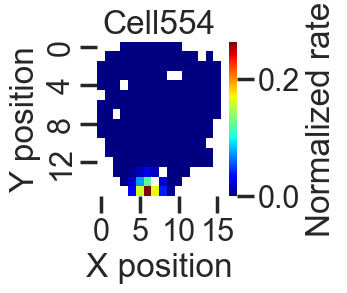

place information 0.950247249181352
coherence 0.4635975990110506
firing rate 0.03611111111111111


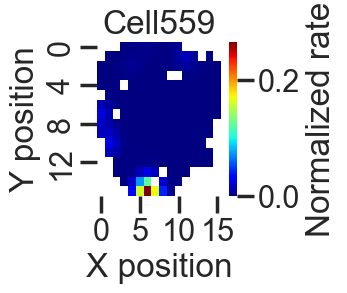

place information 2.0153288313923836
coherence 0.4031892562490704
firing rate 0.0033333333333333335


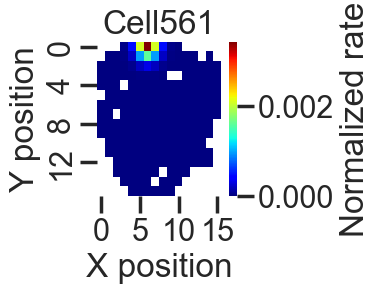

place information 0.988949192160162
coherence 0.4045476752066211
firing rate 0.0016666666666666668


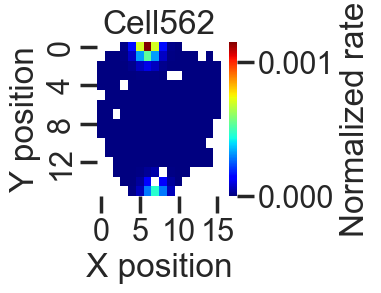

place information 2.0153288313923845
coherence 0.40318925624907087
firing rate 0.0005555555555555556


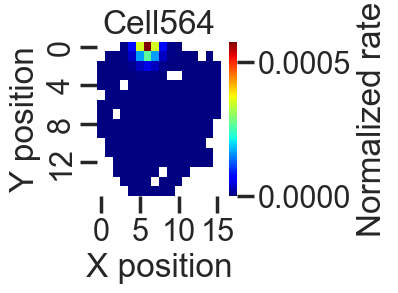

In [87]:
####
bins_position = 16
ls_tmp = []
fr_maps_all = []
PC_test_b_all = []
irec = sess
# for irec in range(0,1): #len(x)):
    
#     if (drug_list[irec] == 'SAL') or (drug_list[irec] == 'PCP') or (drug_list[irec] == 'RSK'):
#     if (mouse_list[irec] == 'M15'):


ksort_path = ksort_HPC_path_matched[irec]
print('experiment',ksort_path)

size_to = []
size_to = np.min([spikes_binned_all_HPC[irec].shape[1],beh_binned_all[irec][0].size]) - 1



# # baseline
start = 0
end = 30*60*250
occ_b, rate_maps_temp_b, rate_maps_temp_b_sm, LinMapsTemp_temp, p_info_b, coh_b, PC_test_b = [], [],[],[],[],[],[]   
occ_b, rate_maps_temp_b, rate_maps_temp_b_sm, LinMapsTemp_temp, p_info_b, coh_b, PC_test_b = place_cell_properties(spikes_binned_all_HPC[irec][:,start:end],
                                                                  np.array([beh_binned_all[irec][0][start:end],
                                                                            beh_binned_all[irec][1][start:end]]),
                                                                            bins_position,250,False)

PC_test_b_all.append(PC_test_b)

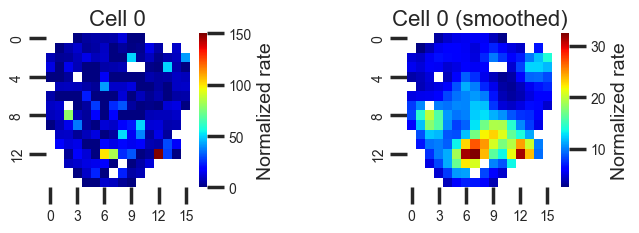

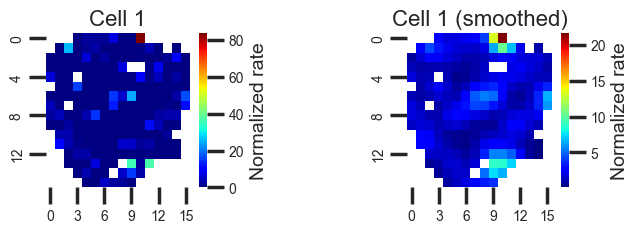

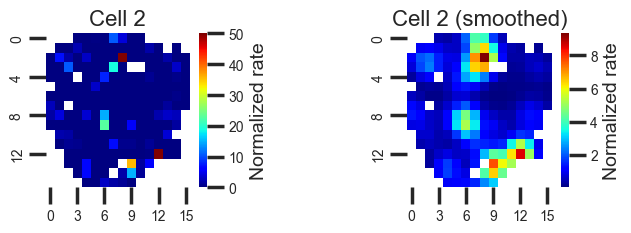

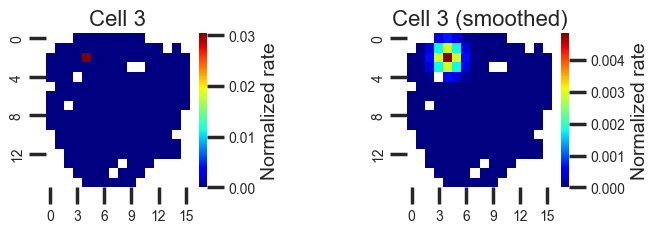

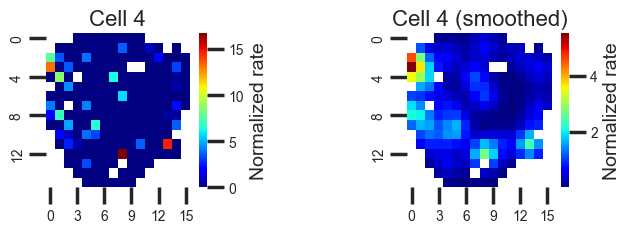

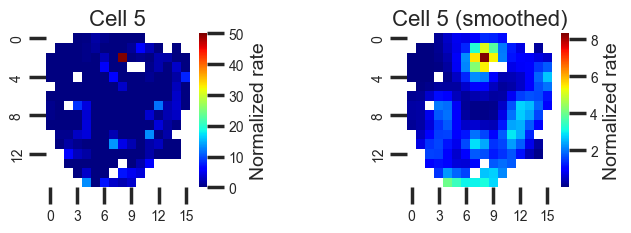

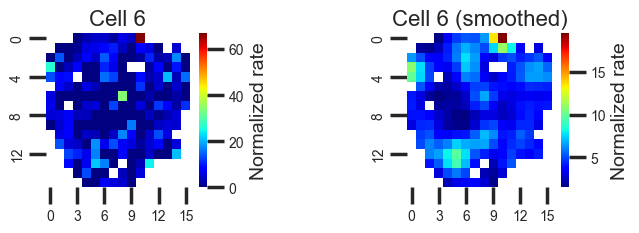

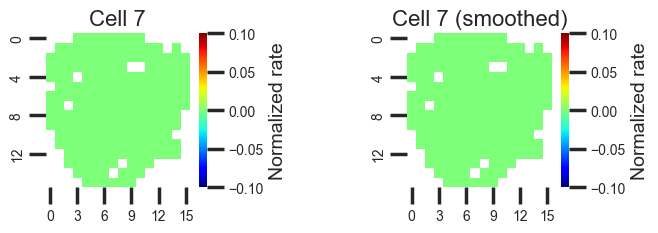

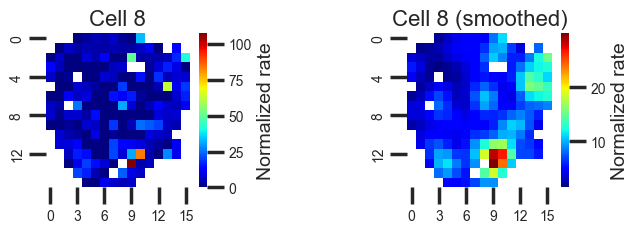

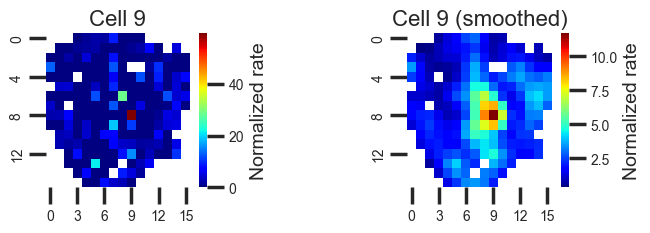

In [113]:
# ## plot firing rate maps
# for icell in range(0,len(rate_maps_temp_b)):
#     fig = plt.figure(figsize=(2, 2))
#     ax = fig.add_subplot(1, 1, 1)
#     sns.heatmap(rate_maps_temp_b[icell], cmap='jet', ax=ax, cbar_kws={'label': 'Normalized rate'})
#     ax.set_xlabel('X position')
#     ax.set_ylabel('Y position')
#     fname = 'Cell' + str(icell)
#     ax.set_title(fname)
#     plt.show()   
    

for icell in range(0,10): #len(rate_maps_temp_b)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
    
    # Plot for the first column
    heatmap1 = sns.heatmap(rate_maps_temp_b[icell], cmap='jet', ax=axes[0], cbar_kws={'label': 'Normalized rate'})
    # axes[0].set_xlabel('X position')
    # axes[0].set_ylabel('Y position')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize=10)
    axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize=10)
    axes[0].set_title('Cell ' + str(icell), fontsize=16)
    
    cbar = heatmap1.collections[0].colorbar
    cbar.set_label('Normalized rate', size=14)  # Set the font size for 'Normalized rate'
    cbar.ax.tick_params(labelsize=10)

    # Plot for the second column (assuming a replication of the first for demonstration)
    heatmap2 = sns.heatmap(rate_maps_temp_b_sm[icell], cmap='jet', ax=axes[1], cbar_kws={'label': 'Normalized rate'})
    # axes[1].set_xlabel('X position')
    # axes[1].set_ylabel('Y position')
    
    axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize=10)
    axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize=10)
    axes[1].set_title('Cell ' + str(icell) + ' (smoothed)', fontsize=16)
    
    cbar = heatmap2.collections[0].colorbar
    cbar.set_label('Normalized rate', size=14)  # Set the font size for 'Normalized rate'
    cbar.ax.tick_params(labelsize=10)
    
    plt.subplots_adjust(wspace=1)  # Adjust space between plots. You can modify the value as per your requirements.
    plt.show()


In [46]:
####
bins_position = 16
ls_tmp = []
fr_maps_all = []
PC_test_b_all = []
fs = 50
t_start = 0*60*fs
t_end = 30*60*fs

for irec in range(0,1): #len(x)):
    
#     if (drug_list[irec] == 'SAL') or (drug_list[irec] == 'PCP') or (drug_list[irec] == 'RSK'):
#     if (mouse_list[irec] == 'M15'):


    ksort_path = ksort_HPC_path_matched[irec]
    print('experiment',ksort_path)

#     size_to = []
#     size_to = np.min([spikes_binned_all_HPC[irec].shape[1],beh_binned_all[irec][0].size]) - 1



    # baseline
    occ_b, rate_maps_temp_b, p_info_b, coh_b, PC_test_b = [], [],[],[],[]   
    occ_b, rate_maps_temp_b, p_info_b, coh_b, PC_test_b = place_cell_properties(spk_down[:,t_start:t_end],
                                                                      [x_down[t_start:t_end],y_down[t_start:t_end]],
                                                                                bins_position,fs,False)
    
    PC_test_b_all.append(PC_test_b)

experiment C:\Users\fentonlab\Desktop\Tony\Neurotar_HPC_ketamine\SPK\electrophysiology\2022-07-27_07-41-00_M015_SAL_PFC_HPC_0_0_0mpk_HPCprobe


NameError: name 'spk_down' is not defined

In [28]:
occ_b

array([[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 9.800000e-01, 2.638000e+01, 1.057576e+03,
        6.276000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.904000e+00, 9.586000e+01, 4.979040e+02, 3.988000e+00,
        1.436400e+01, 3.040000e-01, 2.120000e-01, 2.472000e+00,
        8.000000e-02, 4.680000e-01, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 3.680000e-01, 1.181200e+01,
        3.088000e+00, 2.000000e-01, 0.000000e+00, 0.000000e+00,
        2.280000e-01, 3.600000e-02, 0.000000e+00, 0.000000e+00,
        2.240000e-01, 7.000000e-01, 0.000000e+00, 0.000000e+00],
       [0.000000e+00, 0.000000e+00, 2.360000e-01, 2.320000e-01,
        4.800000e-02, 0.000000e+00, 0.000000e+00, 2.000000e-02,
        2.280000e-01, 9.200000e-02, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 7.400000e+00, 8

In [ ]:


###

def normalizer(a):
    out = []
    if (np.nanmax(a) - np.nanmin(a)) == 0:
        out = (a-np.nanmin(a))
    if (np.nanmax(a) - np.nanmin(a)) != 0:
        out = (a-np.nanmin(a))/(np.nanmax(a) - np.nanmin(a))
        
    return out

####

def fr_map_ang(spk_data, beh_data, binsxy, fsrate):
    from scipy.ndimage import gaussian_filter
    
    occ, rate_maps_temp= [], []
    
    Xcenter = beh_data[0] - (np.nanmax(beh_data[0]) + np.nanmin(beh_data[1])) / 2
    Ycenter = beh_data[1] - (np.nanmax(beh_data[1]) + np.nanmin(beh_data[0])) / 2
    
    alpha = np.arctan2(Ycenter, Xcenter)

    L_occ = np.histogram(alpha, bins=binsxy)[0] /fsrate
    LinMapsTemp_temp = [np.histogram(alpha, bins=binsxy, weights=s)[0] / L_occ
         for s in spk_data]
    
    LinMapsTemp = [normalizer(gaussian_filter(np.nan_to_num(p), sigma=1)) for p in LinMapsTemp_temp]
    

    return LinMapsTemp

####

In [ ]:


## spk is cell x time
## x and y positions in time
## win_legth which is the length of the path

def overdispersion(spk,xframes,yframes,iPosframes,win_length, thresh, frame, ipos_mode):

    Nbins = 16
    edgelength = 256/Nbins
    edges = np.arange(0,257,edgelength)
    sampRate = 7.5 # number of samples in a second

    occ_all = []
    rate_maps_all = []
    mean_fr_all = []
    mask_high_fr_all = []
    mask_deltaipos_all = []
    observed_rate_all = []
    expected_rate_all = []
    z_all = []
    
    binx_all = []
    biny_all = []
        
    if frame == "room":
        x,y,ipos = [],[],[]
        x = np.squeeze(xframes[0])
        y = np.squeeze(yframes[0])  
        ipos = iPosframes[0][0] 
        
    if frame == "arena":
        x,y,ipos = [],[],[]
        x = np.squeeze(xframes[1])
        y = np.squeeze(yframes[1])   
        ipos = iPosframes[0][1]      
    print('ipos_shape',ipos.shape)
    
    deltaipos = []
    deltaipos = iPosframes[0][0] - iPosframes[0][1] 
    
    # COMPUTING THE RATE MAPS
    for icell in range(0,spk.shape[0]):
        occ = []
        rate_maps_temp = []

        ## remove nans

        idx_nan = []
        idx_nan = np.invert(np.isnan(x) | np.isnan(y))
        
        mean_fr = []
        mean_fr = np.nansum(spk[icell])/(spk[icell].size/sampRate)
        

        # compute position map
        occ = np.histogram2d(x[idx_nan], y[idx_nan], bins=edges)[0]/sampRate
        # compute firing rate map normalized by occupancy
        rate_maps_temp = [np.histogram2d(x[idx_nan], y[idx_nan], bins=edges, weights=spk[icell][idx_nan])[0] / occ]

        # plot firing rate map per cell
        figure, axes = plt.subplots(figsize=(3,3))         
        sns.heatmap(rate_maps_temp[0])
        plt.show()
        
        
        ## not sure if that is real
        if mean_fr > 2:
#         if np.max(rate_maps_temp[0]) > 20 or np.max(rate_maps_temp[0]) < 10:
            print('high mean fr', mean_fr)
            print('PC peak rate',np.max(rate_maps_temp[0]))
            continue
        
        mean_fr_all.append(mean_fr)
        occ_all.append(occ)
        rate_maps_all.append(rate_maps_temp)
        
        ## compute overdispersion in windows of 5 seconds
        
        n_windows = []
        n_windows = spk[icell][idx_nan].size // win_length
        print('total number of epochs', n_windows)
        print('length of spiking in samples',spk[icell][idx_nan].size)
        spk_split = []
        
        if (spk[icell][idx_nan].size % win_length) > 0:
            spk_split = np.split(spk[icell][idx_nan][:-(spk[icell][idx_nan].size % win_length)],n_windows)
        if (spk[icell][idx_nan].size % win_length) == 0:
            spk_split = np.split(spk[icell][idx_nan],n_windows)
            
        print('spk.length',spk[icell][idx_nan].size)
        print('one path size',spk_split[0].shape)
        print('check')
        print(spk_split[0])
        print(spk[icell][idx_nan][0:30])

        if (spk[icell][idx_nan].size % win_length) > 0:

            x_split = []
            x_split = np.split(x[idx_nan][:-(spk[icell][idx_nan].size % win_length)],n_windows)
            y_split = []
            y_split = np.split(y[idx_nan][:-(spk[icell][idx_nan].size % win_length)],n_windows)   

            ## per time point compute expected rate, firing rate map sum over time

            bin_x = []
            bin_y = []       

            bin_x = [np.max([0,np.where(x_curr <= edges)[0][0]-1]) for x_curr in x[idx_nan][:-(spk[icell][idx_nan].size % win_length)]]
            bin_y = [np.max([0,np.where(y_curr <= edges)[0][0]-1]) for y_curr in y[idx_nan][:-(spk[icell][idx_nan].size % win_length)]]

        if (spk[icell][idx_nan].size % win_length) == 0:

            x_split = []
            x_split = np.split(x[idx_nan],n_windows)
            y_split = []
            y_split = np.split(y[idx_nan],n_windows)   

            ## per time point compute expected rate, firing rate map sum over time

            bin_x = []
            bin_y = []       

            bin_x = [np.max([0,np.where(x_curr <= edges)[0][0]-1]) for x_curr in x[idx_nan]]
            bin_y = [np.max([0,np.where(y_curr <= edges)[0][0]-1]) for y_curr in y[idx_nan]]
            
        ### ipos per cell
        if ipos_mode == "cell":
            if (spk[icell][idx_nan].size % win_length) > 0:
                deltaipos_split = np.split(deltaipos[icell][idx_nan][:-(spk[icell][idx_nan].size % win_length)],n_windows)
            if (spk[icell][idx_nan].size % win_length) == 0:
                deltaipos_split = np.split(deltaipos[icell][idx_nan],n_windows)        
 
        ### ipos as a population
        if ipos_mode == "population":
            if (spk[icell][idx_nan].size % win_length) > 0:
                deltaipos_split = np.split(np.nansum(deltaipos,axis=0)[idx_nan][:-(spk[icell][idx_nan].size % win_length)],n_windows)
            if (spk[icell][idx_nan].size % win_length) == 0:
                deltaipos_split = np.split(np.nansum(deltaipos,axis=0)[idx_nan],n_windows)        
        
        expected_timeseries = []
        expected_timeseries = [rate_maps_temp[0][bx,by]/sampRate  for bx,by in zip(bin_x,bin_y)]
#         expected_timeseries = [rate_maps_temp[0][bx,by]/sampRate  for bx,by in zip(bin_x,bin_y)]

        expected_timeseries_split = []        
        expected_timeseries_split = np.split(np.concatenate(expected_timeseries, axis=None),n_windows)   

        observed_rate, expected_rate = [], []

        # compute observed rate in the epoch
        observed_rate = [np.sum(p) for p in spk_split]

        #compute expected rate in the epoch from mean firing rate map
        expected_rate = [np.sum(p) for p in expected_timeseries_split]

        mask_highfr = []
        mask_highfr = [s > mean_fr*thresh for s in expected_rate]
        
        mask_ipos = []
        mask_ipos = [np.nanmean(s)>0 for s in deltaipos_split]
        
        mask_deltaipos_all.append(mask_ipos) ## positive means room frame

        z = []
        z = [(o-e)/np.sqrt(e) for o,e in zip(observed_rate,expected_rate)]

        mask_high_fr_all.append(mask_highfr)
        observed_rate_all.append(observed_rate)
        expected_rate_all.append(expected_rate)
        z_all.append(z)
        
        binx_all.append(bin_x)
        biny_all.append(bin_y)
        
        ## plot expected and observed rate
        
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(1,1,1)
        win = np.arange(0,n_windows,1)
        ax.scatter(win, np.hstack(observed_rate)/(win_length/sampRate), color = 'black')
        ax.scatter(win, np.hstack(expected_rate)/(win_length/sampRate), color = 'red')
        ax.plot(mean_fr*np.ones(300), '--', color = 'gray')

        ax.set_ylabel('spikes per second')
        ax.set_xlabel('Path #')
        plt.show()
        
        ## plot z
        
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(1,1,1)
        win = np.arange(0,n_windows,1)
        ax.scatter(win, z, color = 'black')
        ax.set_ylabel('Z')
        ax.set_xlabel('Path #')
        plt.show()        
        
    x, y, spk = [], [], []
        
    return occ_all, rate_maps_all, mean_fr_all, mask_high_fr_all,mask_deltaipos_all, observed_rate_all,expected_rate_all,z_all, binx_all, biny_all
